In [1]:
import os
import pandas as pd
import kagglehub
from tqdm import tqdm
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, IterableDataset, TensorDataset
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
from pathlib import Path

from data_loading.tools import reduce_mem_usage

# Navigate up to the project root and add it to sys.path
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

OVERWRITE = False

/home/riley/base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [77]:
from queue import Queue

example_queue = Queue()
example_queue.put(1)
example_queue.put(2)
example_queue.put(3)
example_queue.put(4)
example_queue.put(5)

print(example_queue.get())

1


In [2]:
# Path to the cached dataset
cache_path = os.path.expanduser("~/.cache/kagglehub/datasets")
data_path = os.path.join(cache_path, "mryanm/luflow-network-intrusion-detection-data-set/versions/240")
curr_dir = os.getcwd()
src_dir = os.path.join(curr_dir, os.pardir)
combined_data_path = os.path.join(src_dir, os.pardir, "data", "luflow_combined.csv")

if not (os.path.exists(data_path) or os.path.exists(combined_data_path)) or OVERWRITE: # if either of the paths exist, don't download
    # Download latest version
    data_path = kagglehub.dataset_download("mryanm/luflow-network-intrusion-detection-data-set")

if os.path.exists(combined_data_path) and not OVERWRITE:
    print(f"Combined data path: {combined_data_path}")
else:
    print(f"Data path: {data_path}")

Combined data path: /home/riley/networking_llm/src/eda/../../data/luflow_combined.csv


Data is in different folders seperated by year, month, and day. For ease of loading, I opted to combine these into a single csv.

In [3]:
def save_luflow(data_path, save_path):
    first_write = True  # Track if it's the first write to include headers

    # Load and combine each CSV
    for year in tqdm(sorted(os.listdir(data_path))):  # Sorting for consistency
        year_path = os.path.join(data_path, year)
        if os.path.isdir(year_path):
            for month in sorted(os.listdir(year_path)):
                month_path = os.path.join(year_path, month)
                if os.path.isdir(month_path):
                    for day in sorted(os.listdir(month_path)):
                        day_path = os.path.join(month_path, day)
                        if os.path.isdir(day_path):
                            for file in os.listdir(day_path):
                                if file.endswith(".csv"):
                                    full_path = os.path.join(day_path, file)

                                    # Read in chunks (adjust chunksize as needed)
                                    for chunk in pd.read_csv(full_path, chunksize=10_000):
                                        # Extract date info
                                        try:
                                            y, m, d = map(int, file.split(".")[:3])
                                            chunk["Year"] = y
                                            chunk["Month"] = m
                                            chunk["Day"] = d
                                            chunk['label'] = pd.Categorical(chunk['label']).codes
                                        except ValueError:
                                            print(f"Skipping malformed filename: {file}")
                                            continue

                                        # Append to file (write header only once)
                                        chunk.to_csv(save_path, mode='a', header=first_write, index=False)
                                        first_write = False  # Only write header in the first batch

    print(f"Finished merging CSVs into {save_path}")

if not os.path.exists(combined_data_path) or OVERWRITE:
    save_luflow(data_path, combined_data_path)
    # remove cache data_path
    os.system(f"rm -rf {data_path}")

In [4]:
data = pd.read_csv(combined_data_path, nrows=50_000)
data = reduce_mem_usage(data)
data.head()

Memory usage after optimization is: 2.96 MB
Decreased by 59.2%


/home/riley/base/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration,Year,Month,Day
0,7.500000,342,3679,786,9200.0,5.437500,2,2,6,786,57392.0,1592533725648144,1592533725632946,21860.917969,0,0.015198,2020,6,19
1,0.000000,0,0,786,55972.0,0.000000,1,1,6,49453,49493.0,1592533744644904,1592533744644904,0.000000,2,0.000000,2020,6,19
2,0.500000,15440,942,786,9300.0,2.203125,3,3,6,786,60512.0,1592533770936279,1592533770933553,36091.753906,0,0.002726,2020,6,19
3,20.217392,622,31010,786,9300.0,1.190430,23,5,6,786,60490.0,159253376770238,15925337672353,37640.355469,0,0.467041,2020,6,19
4,0.000000,0,0,786,59498.0,0.000000,1,1,6,786,9300.0,1592533772973114,1592533772973087,0.000000,0,0.000027,2020,6,19


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500000 entries, 0 to 7499999
Data columns (total 19 columns):
 #   Column         Dtype  
---  ------         -----  
 0   avg_ipt        float32
 1   bytes_in       int32  
 2   bytes_out      int32  
 3   dest_ip        int32  
 4   dest_port      float32
 5   entropy        float16
 6   num_pkts_out   int16  
 7   num_pkts_in    int16  
 8   proto          int8   
 9   src_ip         int32  
 10  src_port       float32
 11  time_end       int64  
 12  time_start     int64  
 13  total_entropy  float32
 14  label          int8   
 15  duration       float16
 16  Year           int16  
 17  Month          int8   
 18  Day            int8   
dtypes: float16(2), float32(4), int16(3), int32(4), int64(2), int8(4)
memory usage: 443.5 MB


In [6]:
data['Day'].value_counts()

Day
22    4204081
21     814816
20     770853
19     765360
23     637677
24     307213
Name: count, dtype: int64

The full dataset is too large to get description stats in a timely manner, so only inspecting a subset. NaN seen for some mean values due to overflow during summation, a consequence of downcasting as we've done.

In [ ]:
data.describe()

/home/riley/base/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/home/riley/base/lib/python3.10/site-packages/numpy/_core/_methods.py:52: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


,avg_ipt,bytes_in,bytes_out,dest_ip,dest_port,entropy,num_pkts_out,num_pkts_in,proto,src_ip,src_port,time_end,time_start,total_entropy,label,duration,Year,Month,Day
count,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,5.000000e+04,5.000000e+04,50000.000000,5.000000e+04,50000.0,50000.0,50000.0
mean,2.407307e+06,1790.459540,4314.988480,2391.093220,11199.555300,inf,9.702760,6.324420,7.097240,15440.747900,43477.520580,1.446742e+15,1.445969e+15,1.535622e+04,0.634300,inf,2020.0,6.0,19.0
std,4.725227e+07,6629.712593,9573.466947,12768.299095,16685.602473,2.111328e+00,27.757714,20.642771,3.681855,37318.476275,19767.471747,4.359535e+14,4.371167e+14,3.318598e+04,0.757347,7.207031e+00,0.0,0.0,0.0
min,0.000000e+00,0.000000,0.000000,174.000000,-1.000000,0.000000e+00,0.000000,0.000000,1.000000,4.000000,-1.000000,1.592536e+10,1.592525e+11,0.000000e+00,0.000000,0.000000e+00,2020.0,6.0,19.0
25%,0.000000e+00,0.000000,90.000000,786.000000,445.000000,1.884766e+00,1.000000,0.000000,6.000000,786.000000,38152.000000,1.592527e+15,1.592527e+15,2.097566e+03,0.000000,7.098913e-05,2020.0,6.0,19.0
50%,3.333333e-01,56.000000,191.000000,786.000000,9200.000000,4.550781e+00,4.000000,1.000000,6.000000,786.000000,52450.000000,1.592533e+15,1.592533e+15,2.146884e+03,0.000000,1.948547e-02,2020.0,6.0,19.0
75%,1.330000e+02,299.000000,4344.000000,786.000000,9200.000000,4.808594e+00,6.000000,6.000000,6.000000,8075.000000,55669.000000,1.592536e+15,1.592536e+15,2.401882e+04,1.000000,1.046875e+00,2020.0,6.0,19.0
max,2.147484e+09,65464.000000,65491.000000,213371.000000,65529.000000,3.042188e+01,255.000000,255.000000,58.000000,328136.000000,65534.000000,1.592536e+15,1.592536e+15,1.270000e+06,2.000000,4.103125e+01,2020.0,6.0,19.0


0 = Benign, 1 = Malicious, 2 = Outlier

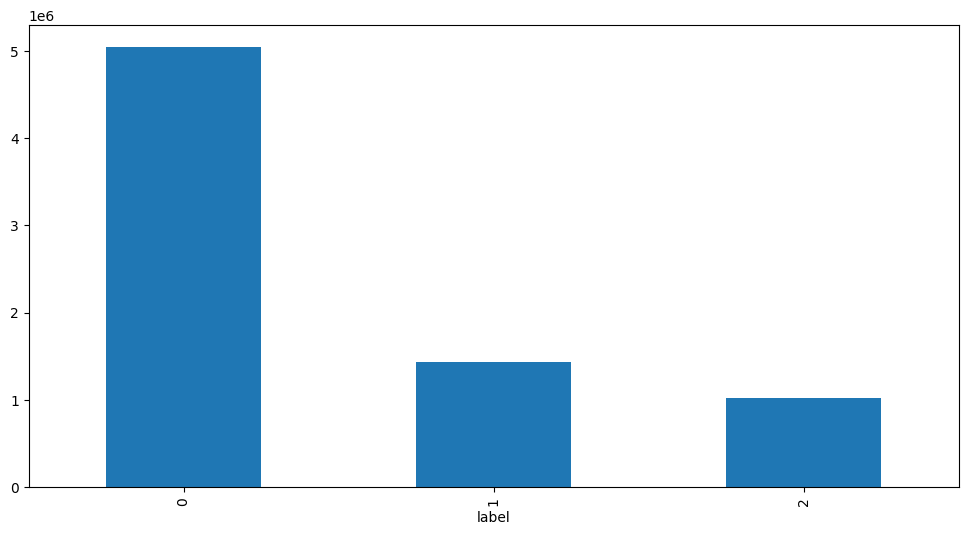

In [8]:
plt.figure(figsize=(12, 6))
data['label'].value_counts().plot(kind='bar')
plt.show()

Majority of flows use TCP (protocol 6)

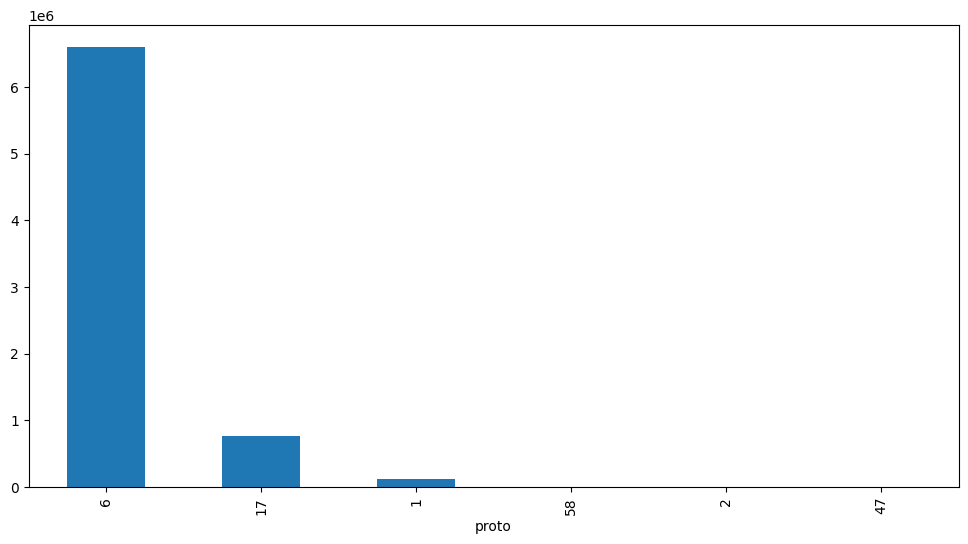

In [9]:
plt.figure(figsize=(12, 6))
data['proto'].value_counts().plot(kind='bar')
plt.show()

To go straight to modeling, run this cell

In [71]:
def preprocess(data_path, num_rows=50_000):
    data = pd.read_csv(data_path, nrows=num_rows)
    data = reduce_mem_usage(data)
    data.dest_port = data.dest_port.fillna(-1).astype('int64')
    data.src_port = data.src_port.fillna(-1).astype('int64')
    data = pd.get_dummies(data, columns=['proto'], drop_first=True, dtype='int8')
    data.drop(['src_ip', 'dest_ip', 'time_start', 'time_end'], axis=1, inplace=True)
    data = data[data.label != 2] # remove outlier class
    return data

protocols = {'6', '17', '47', '50', '51', '58', '89', '132'} # assume '1' is dropped
data = preprocess(combined_data_path, 750_000)
for proto in protocols:
    col_name = f'proto_{proto}'
    if col_name not in data.columns:
        data[col_name] = 0

data.head()

Memory usage after optimization is: 44.35 MB
Decreased by 59.2%


/home/riley/base/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/home/riley/base/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,avg_ipt,bytes_in,bytes_out,dest_port,entropy,num_pkts_out,num_pkts_in,src_port,total_entropy,label,...,Month,Day,proto_6,proto_17,proto_47,proto_58,proto_50,proto_51,proto_132,proto_89
0,7.500000,342,3679,9200,5.437500,2,2,57392,21860.917969,0,...,6,19,1,0,0,0,0,0,0,0
2,0.500000,15440,942,9300,2.203125,3,3,60512,36091.753906,0,...,6,19,1,0,0,0,0,0,0,0
3,20.217392,622,31010,9300,1.190430,23,5,60490,37640.355469,0,...,6,19,1,0,0,0,0,0,0,0
4,0.000000,0,0,59498,0.000000,1,1,9300,0.000000,0,...,6,19,1,0,0,0,0,0,0,0
5,0.000000,0,0,59512,0.000000,1,1,9300,0.000000,0,...,6,19,1,0,0,0,0,0,0,0


In [72]:
data.columns

Index(['avg_ipt', 'bytes_in', 'bytes_out', 'dest_port', 'entropy',
       'num_pkts_out', 'num_pkts_in', 'src_port', 'total_entropy', 'label',
       'duration', 'Year', 'Month', 'Day', 'proto_6', 'proto_17', 'proto_47',
       'proto_58', 'proto_50', 'proto_51', 'proto_132', 'proto_89'],
      dtype='object')

Columns to drop: src/dest_ip, time_start/end

In [53]:
cols_to_scale = ['avg_ipt', 'bytes_in', 'bytes_out', 'num_pkts_in', 'num_pkts_out', 'total_entropy', 'entropy', 'duration']
X_train, X_test, y_train, y_test = train_test_split(data.drop(['label', 'Year', 'Month', 'Day'], axis=1), data['label'], test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)

X_train_normal = X_train[y_train == 0]
X_train_outliers = X_train[y_train == 1]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train_normal.to_numpy(), dtype=torch.float32)
X_train, X_val = X_train[:int(0.8 * len(X_train))], X_train[int(0.8 * len(X_train)):]

# Create DataLoader for batch training
train_dataset = TensorDataset(X_train)
val_dataset = TensorDataset(X_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [54]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.BatchNorm1d(input_dim // 2),
            nn.LeakyReLU(),
            nn.Linear(input_dim // 2, input_dim // 3),
            nn.BatchNorm1d(input_dim // 3),
            nn.LeakyReLU(),
            nn.Linear(input_dim // 3, 1),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(1, input_dim // 3),
            nn.BatchNorm1d(input_dim // 3),
            nn.LeakyReLU(),
            nn.Linear(input_dim // 3, input_dim // 2),
            nn.BatchNorm1d(input_dim // 2),
            nn.LeakyReLU(),
            nn.Linear(input_dim // 2, input_dim),
            nn.LeakyReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize model
input_dim = X_train.shape[1] # currently 18
model = Autoencoder(input_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model_path = os.path.join(src_dir, "nids_helpers/detection_model/autoencoder.pth")
scaler_path = os.path.join(src_dir, "nids_helpers/detection_model/scaler.pkl")

In [55]:
def augment_flow_data(x, noise_factor=0.05):
    noise = torch.randn_like(x) * noise_factor
    return x + noise

In [57]:
# Train the autoencoder
num_epochs = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_losses = []
val_losses = []

patience = 2
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    total_train_loss = 0
    batch_train_losses = []

    # Initialize running_loss before the loop
    running_loss = 0.0

    # Create tqdm object without initial postfix
    pbar = tqdm(train_loader)

    model.train()
    #for batch_idx, batch in enumerate(train_loader):
    for batch in pbar:
        data = batch[0]
        data = augment_flow_data(data)
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed = model(data)
        loss = criterion(reconstructed, data)  # MSE loss
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        batch_train_losses.append(loss.item())
        running_loss = np.mean(batch_train_losses)
        pbar.set_postfix({"running_loss": f"{running_loss:.0f}"})


    epoch_train_loss = total_train_loss / len(train_loader)
    train_losses.append(epoch_train_loss)

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            data = batch[0].to(device)
            reconstructed = model(data)
            loss = criterion(reconstructed, data)
            total_val_loss += loss.item()

    epoch_val_loss = total_val_loss / len(val_loader)
    val_losses.append(epoch_val_loss)

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        counter = 0
        torch.save(model.state_dict(), model_path)
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            print(f"Train Loss: {epoch_train_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}")
            break

    print(f"Train Loss: {epoch_train_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}")

Epoch 1/20


100%|██████████| 7430/7430 [00:18<00:00, 402.14it/s, running_loss=150329979]


Train Loss: 150329978.516285, Validation Loss: 146340579.625404
Epoch 2/20


100%|██████████| 7430/7430 [00:18<00:00, 402.95it/s, running_loss=139677096]


Train Loss: 139677095.507941, Validation Loss: 135697069.636168
Epoch 3/20


100%|██████████| 7430/7430 [00:18<00:00, 400.67it/s, running_loss=123149633]


Train Loss: 123149632.928129, Validation Loss: 115976203.319699
Epoch 4/20


100%|██████████| 7430/7430 [00:18<00:00, 404.46it/s, running_loss=103590341]


Train Loss: 103590340.852759, Validation Loss: 114047892.008611
Epoch 5/20


100%|██████████| 7430/7430 [00:18<00:00, 395.03it/s, running_loss=82574083]


Train Loss: 82574083.030417, Validation Loss: 69015806.292788
Epoch 6/20


100%|██████████| 7430/7430 [00:18<00:00, 396.32it/s, running_loss=62540185]


Train Loss: 62540185.120323, Validation Loss: 52364329.181916
Epoch 7/20


100%|██████████| 7430/7430 [00:18<00:00, 398.00it/s, running_loss=46605874]


Train Loss: 46605873.571736, Validation Loss: 47664096.090420
Epoch 8/20


100%|██████████| 7430/7430 [00:18<00:00, 397.25it/s, running_loss=37769653]


Train Loss: 37769652.962988, Validation Loss: 41989950.202906
Epoch 9/20


100%|██████████| 7430/7430 [00:18<00:00, 398.44it/s, running_loss=35416627]


Train Loss: 35416626.559085, Validation Loss: 45700800.212056
Epoch 10/20


100%|██████████| 7430/7430 [00:18<00:00, 396.62it/s, running_loss=30279997]


Train Loss: 30279996.604172, Validation Loss: 28162012.371502
Epoch 11/20


100%|██████████| 7430/7430 [00:18<00:00, 398.36it/s, running_loss=25604214]


Train Loss: 25604214.100572, Validation Loss: 22293784.901372
Epoch 12/20


100%|██████████| 7430/7430 [00:18<00:00, 403.36it/s, running_loss=21380132]


Train Loss: 21380131.908345, Validation Loss: 21080620.484661
Epoch 13/20


100%|██████████| 7430/7430 [00:18<00:00, 399.16it/s, running_loss=16936641]


Train Loss: 16936641.241756, Validation Loss: 12878074.643972
Epoch 14/20


100%|██████████| 7430/7430 [00:18<00:00, 401.40it/s, running_loss=12588083]


Train Loss: 12588082.841319, Validation Loss: 8714591.158773
Epoch 15/20


100%|██████████| 7430/7430 [00:18<00:00, 401.55it/s, running_loss=8729760] 


Train Loss: 8729760.236692, Validation Loss: 8964542.264801
Epoch 16/20


100%|██████████| 7430/7430 [00:17<00:00, 414.43it/s, running_loss=5592716]


Train Loss: 5592716.343271, Validation Loss: 4446500.335710
Epoch 17/20


100%|██████████| 7430/7430 [00:17<00:00, 416.49it/s, running_loss=3331647]


Train Loss: 3331647.370786, Validation Loss: 32528939.587729
Epoch 18/20


100%|██████████| 7430/7430 [00:18<00:00, 406.98it/s, running_loss=2018072]


Early stopping at epoch 18
Train Loss: 2018072.086605, Validation Loss: 7217485.768030


In [58]:
# evaluate the model on the test set
model.load_state_dict(torch.load(model_path))
model.to(device)
X_test = X_test.to(device)
model.eval()
with torch.no_grad():
    reconstructed = model(X_test)
    test_loss = criterion(reconstructed, X_test)
    print(f"Test Loss: {test_loss.item():.6f}")

Test Loss: 9835108.000000


In [59]:
def compute_reconstruction_error(model, data_loader, device):
    model.eval()
    reconstruction_errors = []
    with torch.no_grad():
        for batch in data_loader:
            data = batch[0].to(device)
            reconstructed = model(data)
            # Calculate MSE for each sample individually (not batch average)
            errors = torch.mean((reconstructed - data) ** 2, dim=1)
            reconstruction_errors.extend(errors.cpu().numpy())
    return np.array(reconstruction_errors)

# For anomalous validation data, use some samples from the outliers
X_val_anomalous = torch.tensor(X_train_outliers.sample(min(len(X_val), len(X_train_outliers))).to_numpy(), dtype=torch.float32)
X_val_anomalous_dataset = TensorDataset(X_val_anomalous)
val_anomalous_loader = DataLoader(X_val_anomalous_dataset, batch_size=32, shuffle=False)

In [60]:
# Compute reconstruction errors
normal_errors = compute_reconstruction_error(model, val_loader, device)
anomalous_errors = compute_reconstruction_error(model, val_anomalous_loader, device)
normal_errors, anomalous_errors

(array([ 5117750.5, 19108572. ,  3656672. , ...,  4130294.2,  4138362.2,
         4138028.5], shape=(59439,), dtype=float32),
 array([17100154., 15329753., 29197500., ..., 15596546., 13927517.,
        21952636.], shape=(59439,), dtype=float32))

In [45]:
def plot_reconstruction_errors(normal_errors, anomalous_errors):
    # Combine normal and anomalous errors
    all_errors = np.concatenate([normal_errors, anomalous_errors])
    # Labels: 0 for normal, 1 for anomalous
    all_labels = np.concatenate([np.zeros(len(normal_errors)), np.ones(len(anomalous_errors))])

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_errors)
    roc_auc = auc(fpr, tpr)

    # Calculate Precision-Recall curve
    precision, recall, pr_thresholds = precision_recall_curve(all_labels, all_errors)
    average_precision = average_precision_score(all_labels, all_errors)

    # Plot the distributions and curves
    plt.figure(figsize=(15, 5))

    # Plot 1: Error distributions
    plt.subplot(1, 3, 1)
    plt.hist(normal_errors, bins=50, alpha=0.5, label='Normal')
    plt.hist(anomalous_errors, bins=50, alpha=0.5, label='Anomalous')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Count')
    plt.legend()
    plt.title('Reconstruction Error Distributions')

    # Plot 2: ROC curve
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()

    # Plot 3: Precision-Recall curve
    plt.subplot(1, 3, 3)
    plt.plot(recall, precision, label=f'AP = {average_precision:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return all_errors, all_labels, pr_thresholds

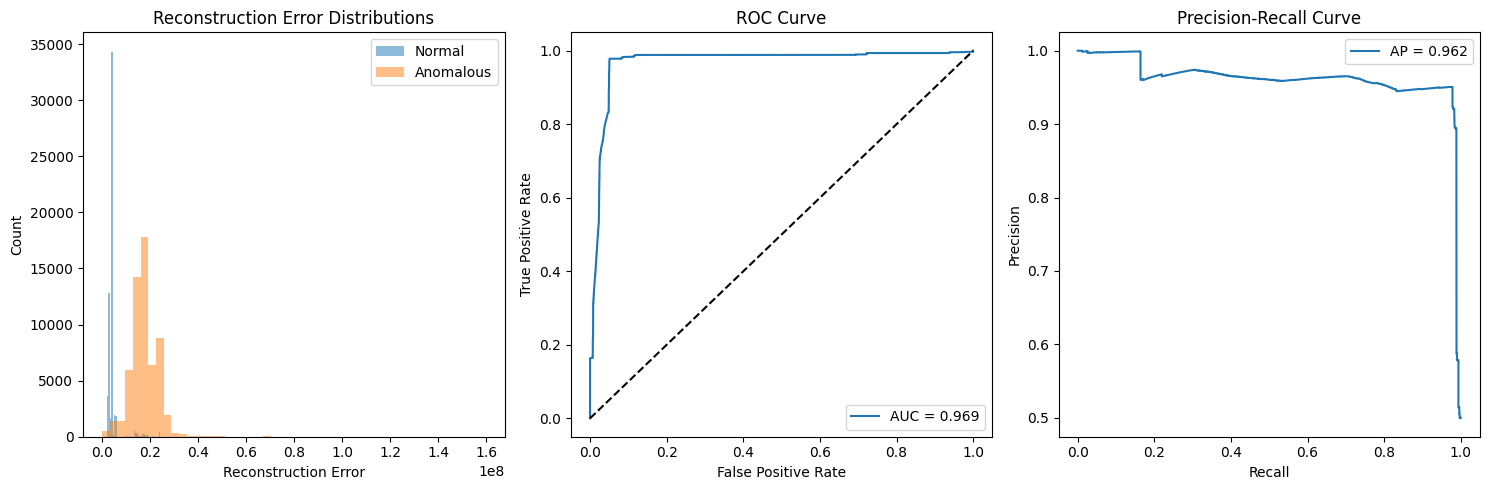

In [61]:
all_errors, all_labels, pr_thresholds = plot_reconstruction_errors(normal_errors, anomalous_errors)

In [62]:
def get_optimal_threshold(pr_thresholds, all_errors, all_labels):
    f1_scores = []
    for threshold in tqdm(pr_thresholds):
        predictions = (all_errors >= threshold).astype(int)
        f1 = f1_score(all_labels, predictions)
        f1_scores.append(f1)

    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = pr_thresholds[optimal_idx]
    best_f1 = f1_scores[optimal_idx]

    print(f"Optimal threshold: {optimal_threshold:.6f}, F1 Score: {best_f1:.4f}")
    return optimal_threshold

In [63]:
optimal_threshold = get_optimal_threshold(pr_thresholds, all_errors, all_labels)

100%|██████████| 49515/49515 [03:05<00:00, 267.56it/s]

Optimal threshold: 5737109.500000, F1 Score: 0.9642


In [64]:
# Step 4: Final anomaly detection function
def detect_anomalies(model, dataloader, threshold, device):
    model.eval()
    predictions = []
    reconstruction_errors = []
    
    with torch.no_grad():
        for batch in dataloader:
            data = batch[0].to(device)
            reconstructed = model(data)
            errors = torch.mean((reconstructed - data) ** 2, dim=1)
            batch_predictions = (errors >= threshold).int()
            
            predictions.extend(batch_predictions.cpu().numpy())
            reconstruction_errors.extend(errors.cpu().numpy())
            
    return np.array(predictions), np.array(reconstruction_errors)


Test Set Performance:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     74085
           1       0.93      0.98      0.96     51568

    accuracy                           0.96    125653
   macro avg       0.96      0.96      0.96    125653
weighted avg       0.96      0.96      0.96    125653


Confusion Matrix:


<Axes: >

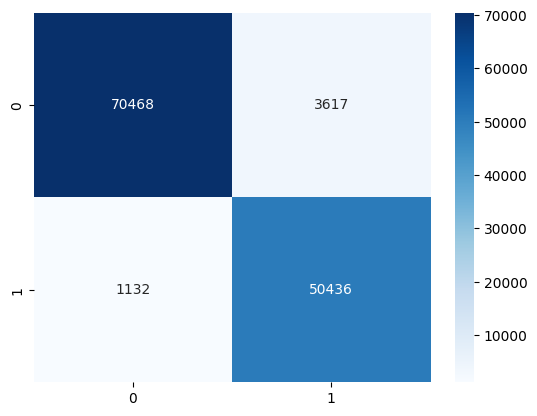

In [65]:
# Create DataLoader for test data with both normal and anomalous samples
test_dataset = TensorDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get ground truth labels
y_test_np = y_test.to_numpy()

# Detect anomalies
predictions, errors = detect_anomalies(model, test_loader, optimal_threshold, device)

# Calculate metrics
print("\nTest Set Performance:")
print(classification_report(y_test_np, predictions))
print("\nConfusion Matrix:")
sns.heatmap(confusion_matrix(y_test_np, predictions), annot=True, fmt='d', cmap='Blues')

In [66]:
# Step 6: Function to predict on new data
def predict_anomaly(model, new_data, scaler, threshold, device, cols_to_scale, one_hot_columns):
    """
    Predict if a new network flow is anomalous
    
    Parameters:
    - model: Trained autoencoder model
    - new_data: Pandas DataFrame with a single flow or multiple flows
    - scaler: Fitted MinMaxScaler
    - threshold: Optimal threshold for anomaly detection
    - device: torch device
    - cols_to_scale: List of columns to scale
    - one_hot_columns: List of columns to one-hot encode
    
    Returns:
    - Predictions (0: normal, 1: anomalous)
    - Reconstruction errors
    """
    # Preprocess the data
    data_processed = pd.get_dummies(new_data, columns=one_hot_columns, drop_first=True, dtype='int8')
    
    # Handle missing columns that might be in the training data but not in new data
    for col in one_hot_columns:
        expected_cols = [f"{col}_{cat}" for cat in data[col].unique()[1:]]  # drop_first=True
        for exp_col in expected_cols:
            if exp_col not in data_processed.columns:
                data_processed[exp_col] = 0
    
    # Scale the numeric columns
    data_processed[cols_to_scale] = scaler.transform(data_processed[cols_to_scale])
    
    # Convert to tensor
    data_tensor = torch.tensor(data_processed.to_numpy(), dtype=torch.float32).to(device)
    
    # Get reconstruction error
    model.eval()
    with torch.no_grad():
        reconstructed = model(data_tensor)
        errors = torch.mean((reconstructed - data_tensor) ** 2, dim=1)
        predictions = (errors >= threshold).int()
    
    return predictions.cpu().numpy(), errors.cpu().numpy()

In [67]:
# save scaler
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
iso_forest = IsolationForest(n_estimators=100, max_samples=0.8, contamination=0.1, random_state=42, n_jobs=-1)
iso_forest.fit(X_train_normal)

IsolationForest(contamination=0.1, max_samples=0.8, n_jobs=-1, random_state=42)

In [17]:
iso_forest_preds = iso_forest.predict(X_test)
iso_forest_preds = np.where(iso_forest_preds == -1, 1, 0)
accuracy_score(y_test, iso_forest_preds)

0.7963413333333333

From the GitHub https://github.com/ruzzzzz/luflow

#### src_ip:
The source IP address associated with the flow. This feature is anonymised to the corresponding Autonomous System

#### src_port:
The source port number associated with the flow.

#### dest_ip:
The destination IP address associated with the flow. The feature is also anonymised in the same manner as before.

#### dest_port:
The destination port number associated with the flow

#### protocol:
The protocol number associated with the flow. For example TCP is 6

#### bytes_in:
The number of bytes transmitted from source to destination

#### bytes_out:
The number of bytes transmitted from destination to source.

#### num_pkts_in:
The packet count from source to destination

#### num_pkts_out:
The packet count from destination to source

#### entropy:
The entropy in bits per byte of the data fields within the flow. This number ranges from 0 to 8.

#### total_entropy:
The total entropy in bytes over all of the bytes in the data fields of the flow

#### avg_ipt:
The mean of the inter-packet arrival times of the flow

#### time_start:
The start time of the flow in seconds since the epoch.

#### time_end:
The end time of the flow in seconds since the epoch

#### duration:
The flow duration time, with microsecond precision

#### label:
The label of the flow, as decided by Tangerine. Either benign, outlier, or malicious

Datasets from https://staff.itee.uq.edu.au/marius/NIDS_datasets/#RA6